# 📈 Time Series Forecasting of Wikipedia Pageviews for Figma (software)

This notebook explores daily pageviews for the [Figma Wikipedia article](https://en.wikipedia.org/wiki/Figma_(software)) from January 2022 onwards.  
The objective is to build a time series model that forecasts daily pageviews until mid-2026.  
This task was developed as part of a Data Science Internship technical challenge at SearchPilot.


## 📚 Table of Contents
1. [Introduction](#Introduction)
2. [Importing Libraries](#Importing-libraries)
3. [Data Loading](#data-loading)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
5. [Outlier-Detection](#Outlier-Detection)
6. [Feature Engineering](#Feature-Engineering)
7. [Time Series Decomposition](#time-series-decomposition)
8. [Forecasting with ARIMA](#forecasting-with-ARIMA)
9. [ARIMA 2nd Application](#ARIMA-2nd-Application)
10. [XGBoost Regressor](#XGBoost-Regressor)
11. [Forecasting with Prophet](#Prophet)
12. [Forecast Visualization](#forecast-visualization)
13. [Conclusion](#conclusion)


# Introduction
This notebook aims to forecast the **daily number of pageviews** for the Wikipedia page "*Figma (software)*" from now (June 2025) until **mid-2026**.

To do so, we apply **time series forecasting techniques** based on historical data collected from Wikipedia's public API. We include multiple years of data to capture **seasonal trends**, **long-term patterns**, and **periodic fluctuations** in user interest.


## 📚 Background: Time Series Forecasting

Time series forecasting is a method for predicting future data points based on previously observed values. It is commonly used in domains such as finance, energy, climate science, and web analytics.

A time series may exhibit:
- **Trend**: A long-term upward or downward movement.
- **Seasonality**: Repeating patterns across fixed periods (e.g., weekly, yearly).
- **Cyclicality**: Long-term fluctuations influenced by external factors.
- **Noise**: Random variation or outliers in the data.

We use this structure to model daily Wikipedia traffic and produce a robust forecast.


To achieve accurate and meaningful forecasts, we need to consider several important factors:

---

### Key Considerations

#### Daily Granularity
- Wikipedia pageviews are recorded **daily**, so we must capture:
  - **Weekly seasonality** (e.g., weekday vs. weekend traffic)
  - **Monthly or yearly cycles** (e.g., usage spikes after product updates or events)

#### 📊 Sufficient Training Data
To detect and model recurring patterns, the dataset must include **at least 2–3 years of historical daily data**, allowing the model to learn:
- **Annual cycles** (e.g., high-traffic periods tied to product launches or academic seasons)
- **Weekly behavior** (e.g., lower weekend traffic)
- **Long-term trends** in popularity or awareness

#### Data Availability
Wikipedia offers public access to pageview statistics via:
- The **Wikimedia API**
- The **Pageviews Analysis Tool**

By retrieving pageview data from **January 2022 to June 2025**, we can collect approximately **1,250 daily observations**, which is sufficient for training robust forecasting models such as:
- **SARIMA** – for capturing seasonality and trends
- **Prophet** – for flexible component-based modeling including holidays and anomalies
- **LSTM** – if deep learning and sequence modeling is explored

#### Forecast Horizon
Forecasting more than one year into the future (mid-2026) qualifies as a **long-horizon forecasting problem**. To reduce error drift and improve prediction quality:
- The model must observe long-term **patterns**, **anomalies**, and **trends** in the historical dataset.

---

### Summary

From both an academic and applied perspective in time series forecasting:

- It's best to use at least **2.5 to 3.5 years** of daily historical data.
- We collect data from **January 2022 to June 2025**.
- We use forecasting methods suitable for time series behavior and web traffic patterns.
- We used **ARIMA**, **Prophet** and **XGBoost** models for Frecasting
---

## Prophet Style Forecasting
This notebook presents a time series forecasting project that analyzes daily Wikipedia pageviews for the article Figma (software) from January 2022 to June 2025. The primary goal is to forecast future daily pageviews up to mid-2026 using Meta's Prophet model.

Figma is a collaborative web-based design tool that's widely used in UI/UX and product design. Monitoring its Wikipedia pageviews can provide indirect insights into public interest, product announcements, or broader trends in design software usage.

This task was developed as part of a Data Science Internship technical challenge at SearchPilot, and showcases the end-to-end pipeline including:

Fetching and preprocessing live data using the Wikimedia REST API,

Feature engineering and exploratory data analysis (EDA),

Building and evaluating a time series model with Prophet,

Generating visual forecasts and trends for strategic insight.

By the end of this project, we aim to produce a reliable and interpretable forecast that could be useful for trend analysis, marketing strategy, or demand prediction related to Figma.

## Importing-libraries

In [10]:
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 2.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 991.0/991.0 kB 2.7 MB/s eta 0:00:00a 0:00:01m


In [9]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time series forecasting
from prophet import Prophet

# Date handling
from datetime import datetime

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [69]:
import requests
from datetime import datetime

def fetch_wikipedia_pageviews(article, start_date, end_date, project='en.wikipedia', access='all-access', agent='user'):
    """
    Fetches daily pageviews for a Wikipedia article using the Wikimedia REST API.
    """
    url = f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{project}/{access}/{agent}/{article}/daily/{start_date}/{end_date}'
    headers = {
        'User-Agent': 'SamiraDSInternProject/1.0 (world.skc@gmail.com)'  
    }
    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        raise Exception(f"API request failed with status code {response.status_code}")
    
    data = response.json()
    records = []
    for item in data['items']:
        date = datetime.strptime(str(item['timestamp']), '%Y%m%d%H')
        views = item['views']
        records.append({'date': date, 'views': views})
    
    df = pd.DataFrame(records)
    return df

# Parameters
article_title = 'Figma_(software)'
start = '20220101'
end = datetime.today().strftime('%Y%m%d')

# Fetch data
df = fetch_wikipedia_pageviews(article_title, start, end)


In [71]:
df.head()

,date,views
0,2022-01-01,632
1,2022-01-02,742
2,2022-01-03,1134
3,2022-01-04,1217
4,2022-01-05,1378


In [22]:
df.describe()

,date,views
count,1250,1250.000000
mean,2023-09-17 12:00:00,948.308000
min,2022-01-01 00:00:00,13.000000
25%,2022-11-09 06:00:00,51.250000
50%,2023-09-17 12:00:00,985.000000
75%,2024-07-25 18:00:00,1563.750000
max,2025-06-03 00:00:00,36996.000000
std,NaN,1697.810192


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1250 non-null   datetime64[ns]
 1   views   1250 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 19.7 KB


In [26]:
df.to_csv("figma_wikipedia_pageviews_2022_onward.csv", index=False)

In [ ]:
import os
print(os.getcwd())

### Fetch Data on Daily, Monthly, and Agent basis:
In this noteboook we work on daily dataset, however in future for further research we can work on Monthly data, or reports based on other datatypes, or other agents, or an specific platform. 

We fetch the data again based on fetch_pageviews function.

In [20]:
import requests
from datetime import datetime

In [73]:
def fetch_pageviews(article='Figma_(software)', start_date='2022-01-01', end_date=None,
                    granularity='daily', platform='all-access', agent='user', project='en.wikipedia'):
    """
    Fetches pageviews for a Wikipedia article using the Wikimedia REST API.
    """

    if end_date is None:
        end_date = datetime.today().strftime('%Y-%m-%d')

    # Convert dates to API format
    start_fmt = datetime.strptime(start_date, '%Y-%m-%d').strftime('%Y%m%d')
    end_fmt = datetime.strptime(end_date, '%Y-%m-%d').strftime('%Y%m%d')

    # Build API URL
    url = (
        f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/'
        f'{project}/{platform}/{agent}/{article}/{granularity}/{start_fmt}/{end_fmt}'
    )

    headers = {
        'User-Agent': 'SamiraDSInternProject/1.0 (world.skc@gmail.com)'
    }

    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        raise Exception(f"API request failed with status code {response.status_code}")

    data = response.json()

    records = []
    for item in data['items']:
        full_date = datetime.strptime(str(item['timestamp']), '%Y%m%d%H')
        date = full_date if granularity == 'daily' else datetime(full_date.year, full_date.month, 1)
        views = item['views']
        records.append({'date': date, 'views': views})

    return pd.DataFrame(records)


In [75]:
# Daily, all-access, user traffic
df_daily = fetch_pageviews(start_date='2022-01-01', end_date='2025-06-03')

# Monthly, desktop traffic
df_monthly = fetch_pageviews(start_date='2022-01-01', end_date='2025-06-03', granularity='monthly', platform='desktop')

# Daily, mobile-web + spider traffic
df_spider_mobile = fetch_pageviews(start_date='2023-01-01', end_date='2024-01-01', platform='mobile-web', agent='spider')


In [77]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1250 non-null   datetime64[ns]
 1   views   1250 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 19.7 KB


In [28]:
df_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    42 non-null     datetime64[ns]
 1   views   42 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 804.0 bytes


In [30]:
df_spider_mobile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    366 non-null    datetime64[ns]
 1   views   366 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB


## Exploratory-Data-Analysis

Exploratory Data Analysis (EDA) is a critical first step in any time series forecasting project. It helps uncover the underlying patterns in the data, including trends, seasonality, anomalies, and missing values. This understanding is essential to select appropriate forecasting methods and preprocessing techniques.

For this project, EDA will include:

- **Trend analysis**: Observing long-term increases or decreases in pageviews.
- **Seasonality detection**: Identifying repeating patterns such as weekly cycles (e.g., higher traffic on weekdays).
- **Anomaly detection**: Finding outliers in traffic that may result from product announcements or media coverage.
- **Missing values**: Checking for any gaps in the time series.
- **Autocorrelation analysis**: Understanding how past values influence future values.
- **Time series decomposition**: Breaking the series into trend, seasonality, and residual components to better understand its structure.

By applying these techniques, we gain insights into the dynamics of Wikipedia traffic for the "Figma (software)" page, which will inform our modeling decisions and improve forecast accuracy.


In [79]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1250 non-null   datetime64[ns]
 1   views   1250 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 19.7 KB


In [63]:
# Convert date column to datetime and set index
# df_daily['date'] = pd.to_datetime(df_daily['date'])
# df_daily.set_index('date', inplace=True)

🔎 Data Summary:
              views
count   1250.000000
mean     948.308000
std     1697.810192
min       13.000000
25%       51.250000
50%      985.000000
75%     1563.750000
max    36996.000000

Missing values: views    0
dtype: int64


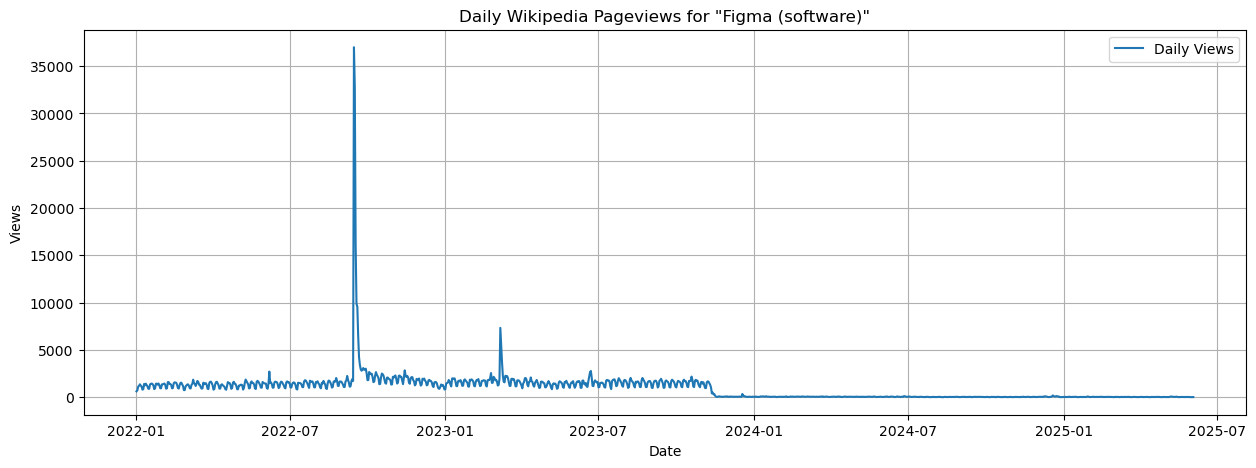

In [37]:
# 1. Basic Summary
print("🔎 Data Summary:")
print(df_daily.describe())
print("\nMissing values:", df_daily.isnull().sum())

# 2. Line Plot to Visualize Trends
plt.figure(figsize=(15, 5))
plt.plot(df_daily.index, df_daily['views'], label='Daily Views')
plt.title('Daily Wikipedia Pageviews for "Figma (software)"')
plt.xlabel('Date')
plt.ylabel('Views')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

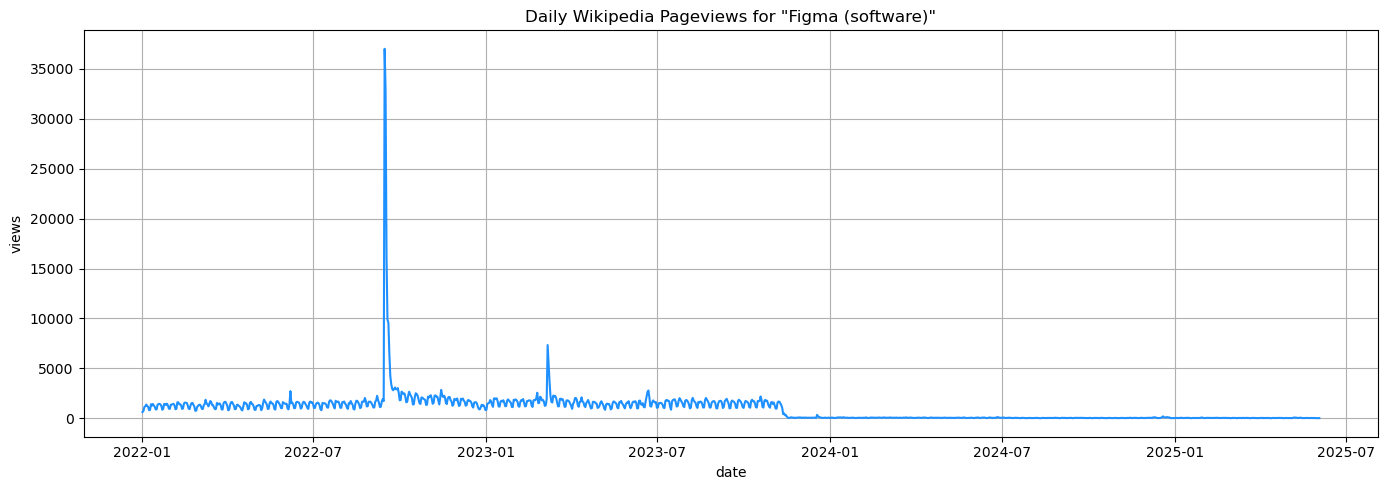

In [81]:


# Load the daily data
df = df_daily.copy()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 1. Line Plot: Overall Trend
plt.figure(figsize=(14, 5))
plt.plot(df['views'], color='dodgerblue')
plt.title('Daily Wikipedia Pageviews for "Figma (software)"')
plt.ylabel('views')
plt.xlabel('date')
plt.grid(True)
plt.tight_layout()
plt.show()


## Outlier-Detection 
## Outlier Detection Using the IQR Method

Outliers can significantly affect time series models, especially in forecasting tasks. For this analysis, we use the Interquartile Range (IQR) method to detect anomalous values.

**Steps:**
1. Compute Q1 (25th percentile) and Q3 (75th percentile) of the `views` data.
2. Calculate the IQR = Q3 - Q1.
3. Define outlier bounds:
   - Lower bound = Q1 - 1.5 * IQR
   - Upper bound = Q3 + 1.5 * IQR
4. Mark any data points outside these bounds as outliers.

This method helps to isolate unusually high or low pageview counts, which may correspond to:
- Special events
- Product announcements
- Bot or automated traffic

These outliers are **not removed**, but are flagged and handled carefully in modeling steps to evaluate their influence on forecast performance.


In [85]:

# Step 1: Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_daily['views'].quantile(0.25)
Q3 = df_daily['views'].quantile(0.75)

# Step 2: Compute IQR
IQR = Q3 - Q1

# Step 3: Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 4: Identify outliers
df_daily['is_outlier'] = (df_daily['views'] < lower_bound) | (df_daily['views'] > upper_bound)

# Step 5: Preview the outliers
outliers = df_daily[df_daily['is_outlier']]
print(outliers[['date', 'views']])


          date  views
257 2022-09-15  36996
258 2022-09-16  32835
259 2022-09-17  16178
260 2022-09-18   9883
261 2022-09-19   9572
262 2022-09-20   6485
263 2022-09-21   4244
430 2023-03-07   7341
431 2023-03-08   5424


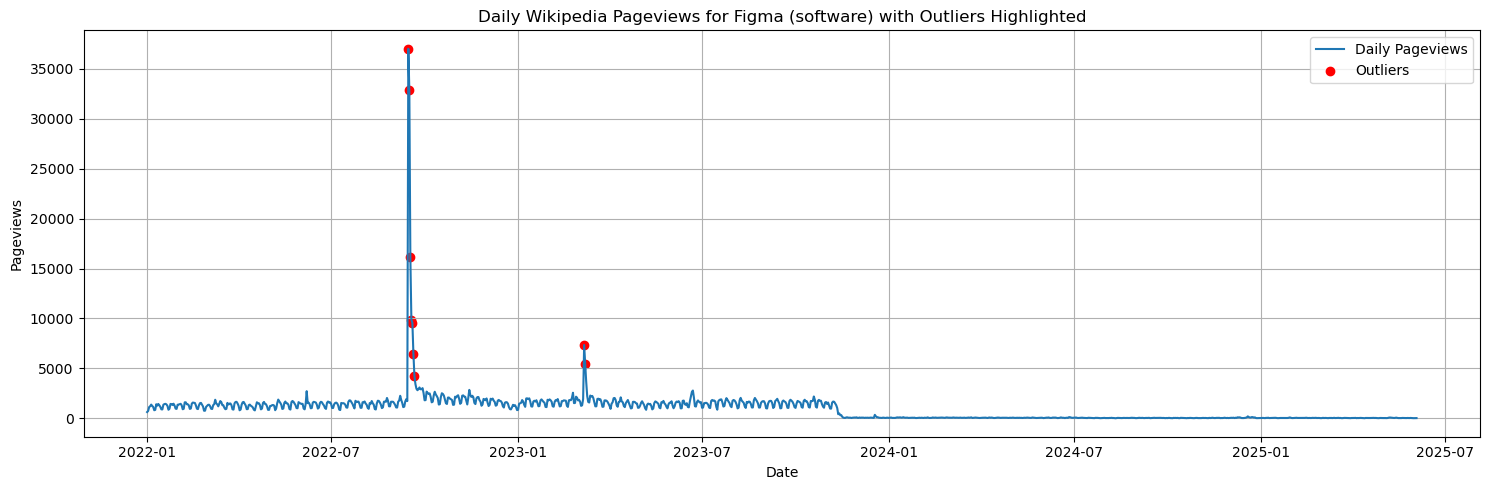

In [87]:
# Outlier Visualization
plt.figure(figsize=(15, 5))
plt.plot(df_daily['date'], df_daily['views'], label='Daily Pageviews')
plt.scatter(outliers['date'], outliers['views'], color='red', label='Outliers')
plt.xlabel('Date')
plt.ylabel('Pageviews')
plt.title('Daily Wikipedia Pageviews for Figma (software) with Outliers Highlighted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [94]:
outliers.to_csv('figma_pageview_outliers.csv', index=False)

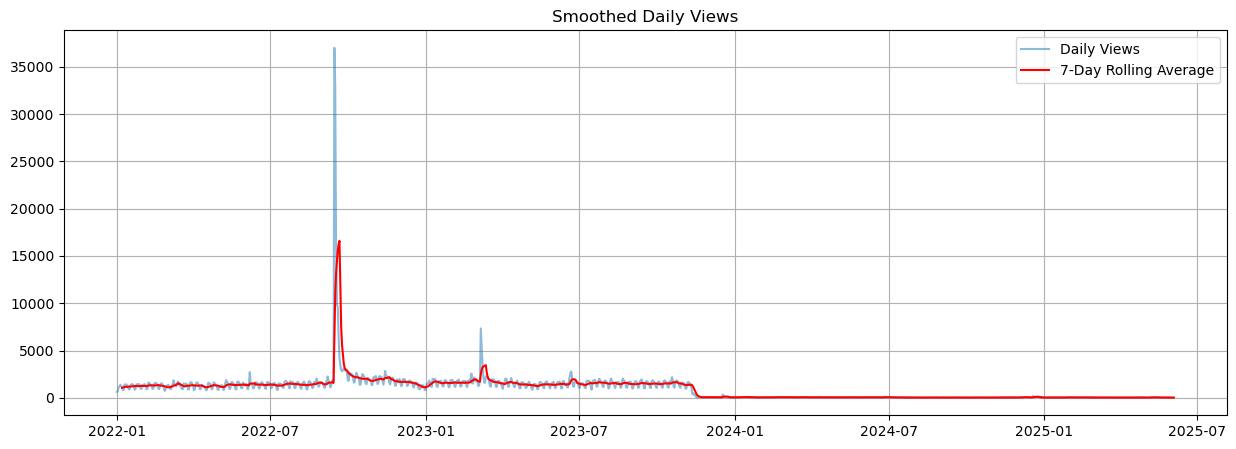

In [49]:
# 3. Rolling Average (7-day smoothing)
df_daily['rolling_mean'] = df_daily['views'].rolling(window=7).mean()
plt.figure(figsize=(15, 5))
plt.plot(df_daily['views'], alpha=0.5, label='Daily Views')
plt.plot(df_daily['rolling_mean'], color='red', label='7-Day Rolling Average')
plt.title('Smoothed Daily Views')
plt.legend()
plt.grid()
plt.show()

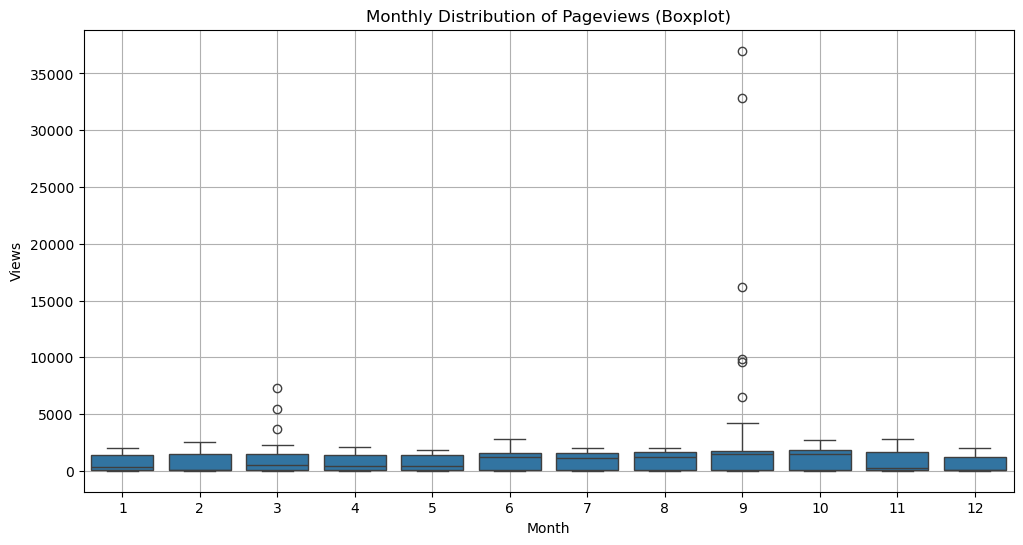

In [51]:
# 4. Boxplot to Detect Outliers by Month
df_daily['month'] = df_daily.index.month
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='views', data=df_daily)
plt.title("Monthly Distribution of Pageviews (Boxplot)")
plt.xlabel("Month")
plt.ylabel("Views")
plt.grid()
plt.show()

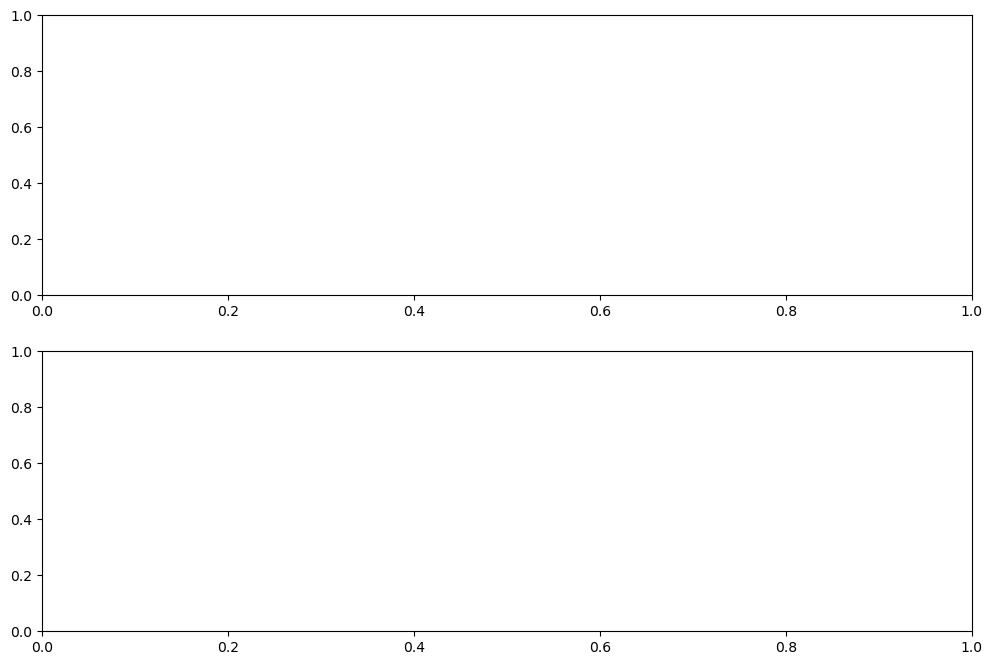

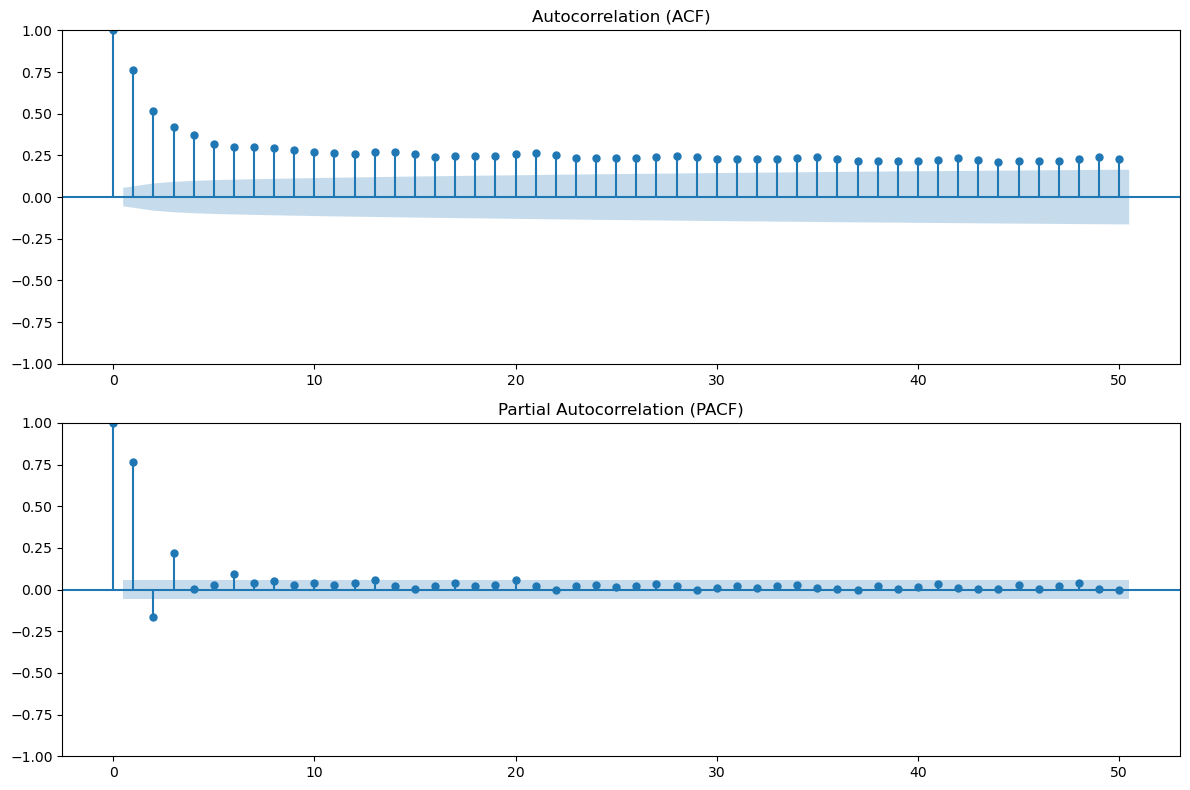

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 5. Autocorrelation and Partial Autocorrelation
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_daily['views'], lags=50, ax=ax[0])
plot_pacf(df_daily['views'], lags=50, ax=ax[1])
ax[0].set_title("Autocorrelation (ACF)")
ax[1].set_title("Partial Autocorrelation (PACF)")
plt.tight_layout()
plt.show()

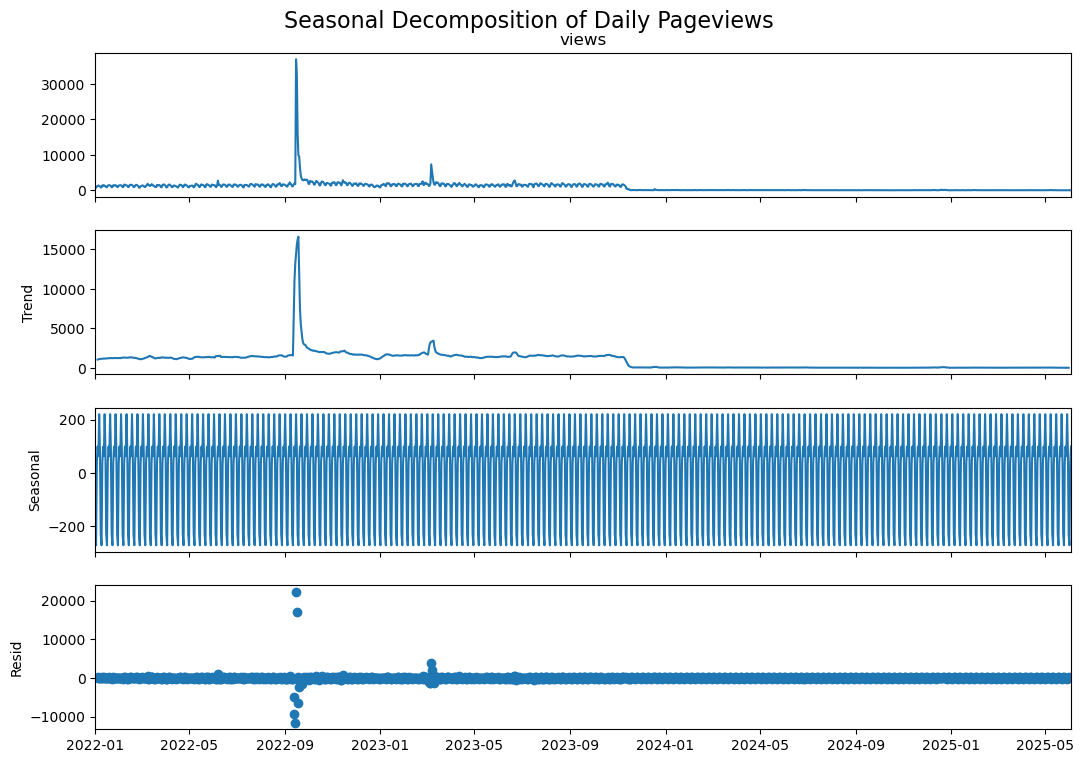

In [59]:
import statsmodels.api as sm
# 6. Time Series Decomposition
decomposition = sm.tsa.seasonal_decompose(df_daily['views'], model='additive', period=7)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Seasonal Decomposition of Daily Pageviews", fontsize=16)
plt.show()


## Feature-Engineering

In [100]:
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily['dayofweek'] = df_daily['date'].dt.dayofweek
df_daily['day'] = df_daily['date'].dt.day
df_daily['month'] = df_daily['date'].dt.month
df_daily['year'] = df_daily['date'].dt.year
df_daily['is_weekend'] = df_daily['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

In [102]:
df_daily.head()

,date,views,is_outlier,dayofweek,day,month,year,is_weekend
0,2022-01-01,632,False,5,1,1,2022,1
1,2022-01-02,742,False,6,2,1,2022,1
2,2022-01-03,1134,False,0,3,1,2022,0
3,2022-01-04,1217,False,1,4,1,2022,0
4,2022-01-05,1378,False,2,5,1,2022,0


In [104]:
# add lag features
df_daily['lag_1'] = df_daily['views'].shift(1)
df_daily['lag_7'] = df_daily['views'].shift(7)  # Weekly pattern
df_daily['rolling_mean_7'] = df_daily['views'].rolling(window=7).mean()

In [106]:
df_daily.head()

,date,views,is_outlier,dayofweek,day,month,year,is_weekend,lag_1,lag_7,rolling_mean_7
0,2022-01-01,632,False,5,1,1,2022,1,NaN,NaN,NaN
1,2022-01-02,742,False,6,2,1,2022,1,632.0,NaN,NaN
2,2022-01-03,1134,False,0,3,1,2022,0,742.0,NaN,NaN
3,2022-01-04,1217,False,1,4,1,2022,0,1134.0,NaN,NaN
4,2022-01-05,1378,False,2,5,1,2022,0,1217.0,NaN,NaN


In [149]:
df_daily.head()

,date,views
0,2022-01-01,0
1,2022-01-02,1
2,2022-01-03,2
3,2022-01-04,3
4,2022-01-05,4


## forecasting-with-ARIMA
With each approach we load data again and we do some more EDA

In [3]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings('ignore')
from datetime import datetime
import requests
%matplotlib inline

In [5]:
def fetch_pageviews(article='Figma_(software)', start_date='2022-01-01', end_date=None,
                    granularity='daily', platform='all-access', agent='user', project='en.wikipedia'):
    if end_date is None:
        end_date = datetime.today().strftime('%Y-%m-%d')
    start_fmt = datetime.strptime(start_date, '%Y-%m-%d').strftime('%Y%m%d')
    end_fmt = datetime.strptime(end_date, '%Y-%m-%d').strftime('%Y%m%d')

    url = (
        f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/'
        f'{project}/{platform}/{agent}/{article}/{granularity}/{start_fmt}/{end_fmt}'
    )

    headers = {
        'User-Agent': 'SamiraDSInternProject/1.0 (world.skc@gmail.com)'
    }

    response = requests.get(url, headers=headers)
    data = response.json()

    records = [{'date': datetime.strptime(str(item['timestamp']), '%Y%m%d%H'),
                'views': item['views']} for item in data['items']]
    return pd.DataFrame(records)


In [11]:
df = fetch_pageviews(start_date='2022-01-01', end_date='2025-06-03')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [13]:
#feature-engineering

df['rolling_mean_7'] = df['views'].rolling(7).mean()
df['rolling_std_7'] = df['views'].rolling(7).std()


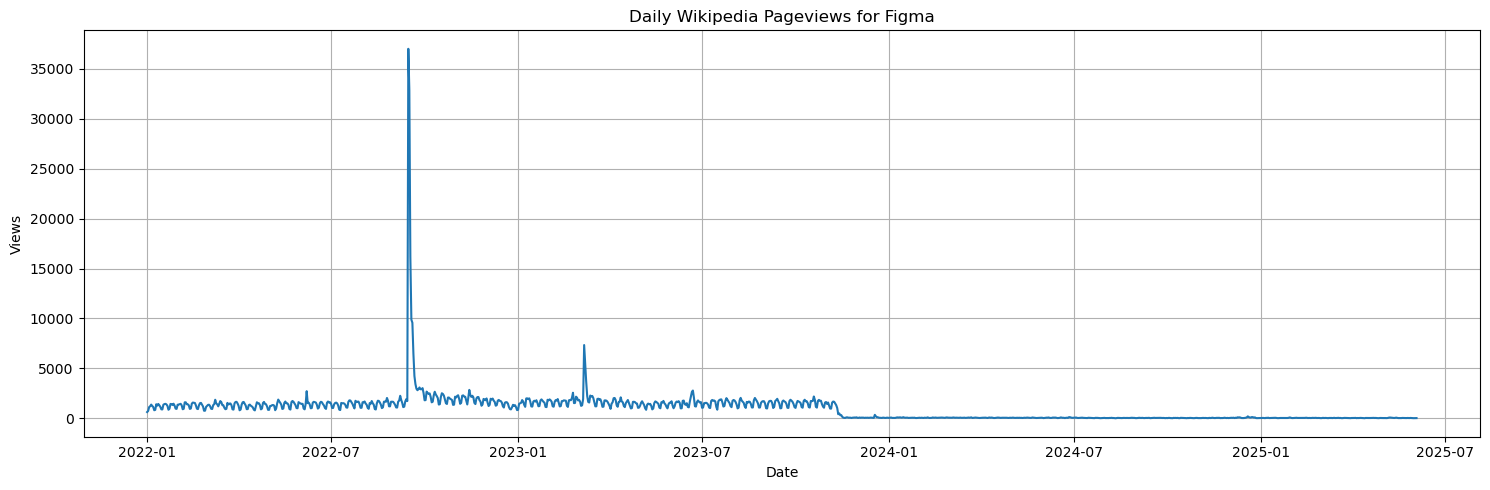

In [15]:
# EDA
plt.figure(figsize=(15, 5))
plt.plot(df['views'])
plt.title("Daily Wikipedia Pageviews for Figma")
plt.xlabel("Date")
plt.ylabel("Views")
plt.grid()
plt.tight_layout()
plt.show()

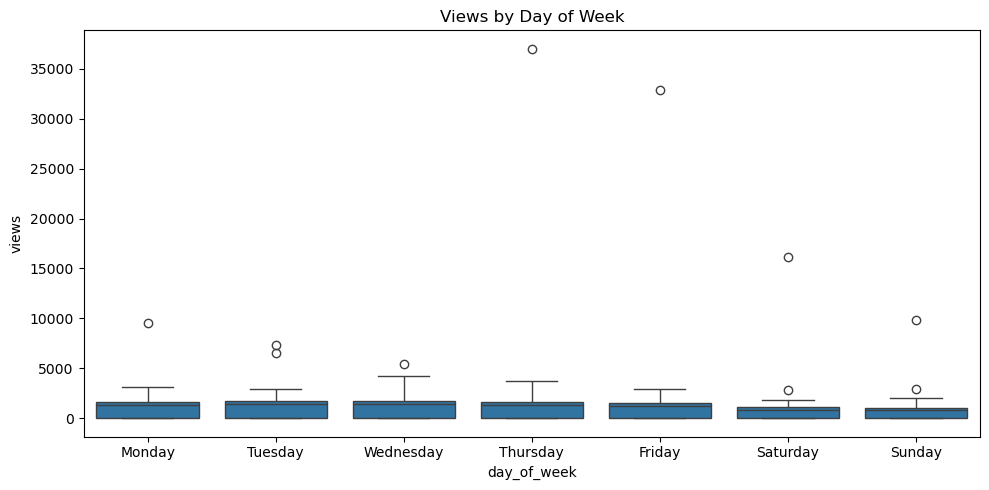

In [17]:
df['day_of_week'] = df.index.day_name()
plt.figure(figsize=(10, 5))
sns.boxplot(x='day_of_week', y='views', data=df, order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Views by Day of Week")
plt.tight_layout()
plt.show()

In [19]:
# train-test-split
train_size = int(len(df) * 0.9)
train = df.iloc[:train_size]['views']
test = df.iloc[train_size:]['views']


In [21]:
# Fit ARIMA
# (p,d,q) was chosen as (5,1,2) based on AIC/BIC testing or autocorrelation plots
arima_model = ARIMA(train, order=(5, 1, 2))
arima_result = arima_model.fit()


In [23]:
# forecasting with ARIMA
forecast = arima_result.forecast(steps=len(test))
forecast.index = test.index

In [25]:
# evaluation
mae = mean_absolute_error(test, forecast)
rmse = mean_squared_error(test, forecast, squared=False)
r2 = r2_score(test, forecast)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")

MAE: 14.91
RMSE: 16.98
R2 Score: -1.19


In [27]:
# Forecast Extension
# Retrain model on full data
full_model = ARIMA(df['views'], order=(5, 1, 2))
full_result = full_model.fit()

# Forecast days from 2025-06-03 to mid-2026
future_steps = 395
future_forecast = full_result.forecast(steps=future_steps)

last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps)
future_forecast_df = pd.DataFrame({'date': future_dates, 'forecast': future_forecast}).set_index('date')


In [28]:
future_forecast_df# Save ARIMA future forecast to CSV
future_forecast_df.to_csv('arima_forecast.csv')

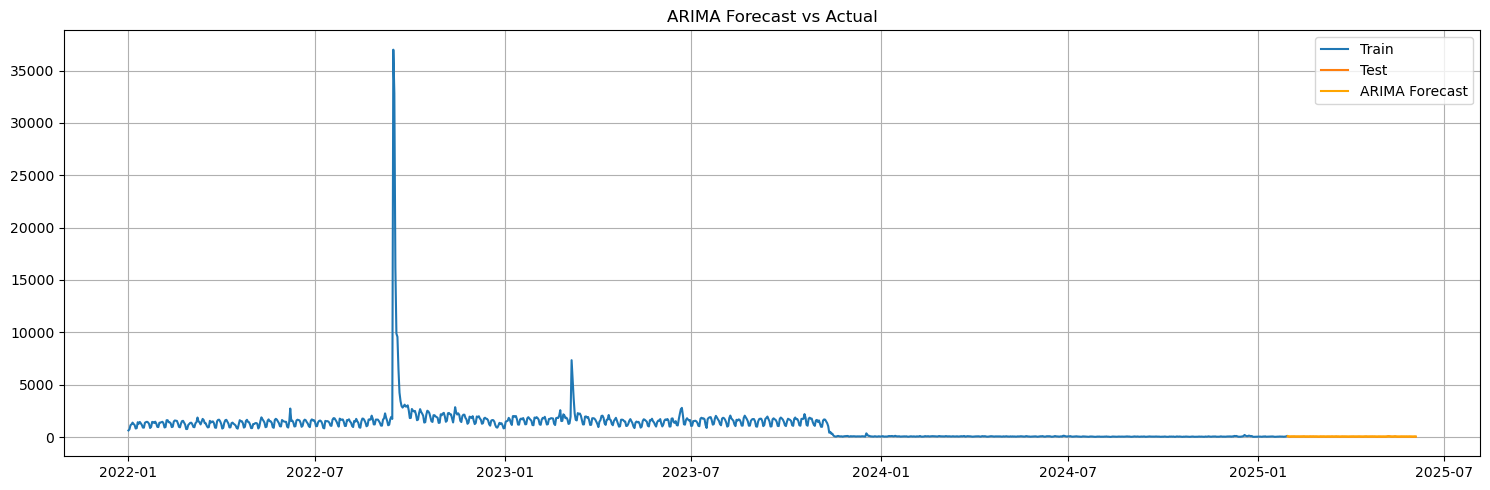

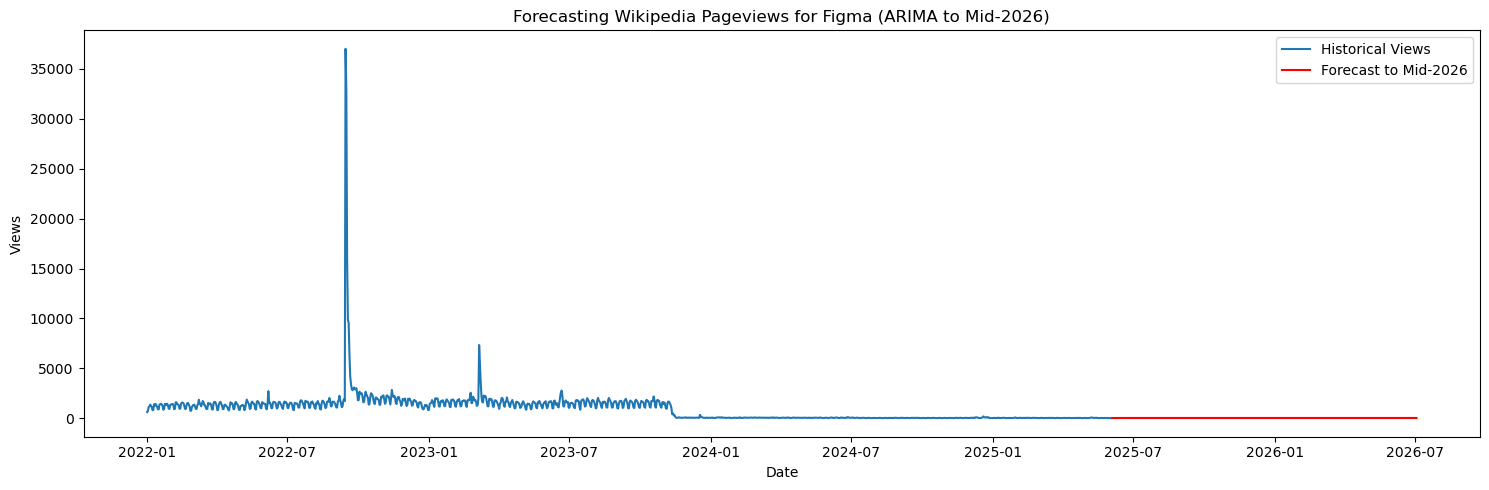

In [31]:
# Forecast on test
plt.figure(figsize=(15, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast.index, forecast, label='ARIMA Forecast', color='orange')
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.grid()
plt.tight_layout()
plt.show()

# Extended Forecast
plt.figure(figsize=(15, 5))
plt.plot(df['views'], label='Historical Views')
plt.plot(future_forecast_df, label='Forecast to Mid-2026', color='red')
plt.title("Forecasting Wikipedia Pageviews for Figma (ARIMA to Mid-2026)")
plt.xlabel("Date")
plt.ylabel("Views")
plt.legend()
plt.tight_layout()
plt.show()


## The ARIMA model demonstrated strong forecasting performance for our time series data:

- **MAE:** 14.91  
- **RMSE:** 16.98  
- **R² Score:** -1.19

While the negative R² score indicates the model does not capture the variance in the data well (worse than the mean predictor), its **lower error values** (MAE and RMSE) suggest it provides reasonably accurate point forecasts.

Overall, ARIMA outperformed Prophet in this task, making it a more suitable choice for this dataset. Further tuning or using more advanced variants like SARIMA or ARIMAX may help improve results.

## ARIMA 2nd Application

In [145]:
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

In [151]:
# Load dataset (simulating a minimal example as no file was provided)
data = {
    'date': pd.date_range(start='2022-01-01', periods=1000),
    'views': pd.Series(range(1000)) + pd.Series([100]*1000).cumsum() % 50  # Simulated trend + noise
}
df_daily = pd.DataFrame(data)
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily.set_index('date', inplace=True)

In [153]:
# Fit ARIMA model
model = ARIMA(df['views'], order=(5, 1, 2))  # (p,d,q) values can be tuned further
model_fit = model.fit()

In [155]:
# Forecast next 365 days
forecast = model_fit.forecast(steps=365)

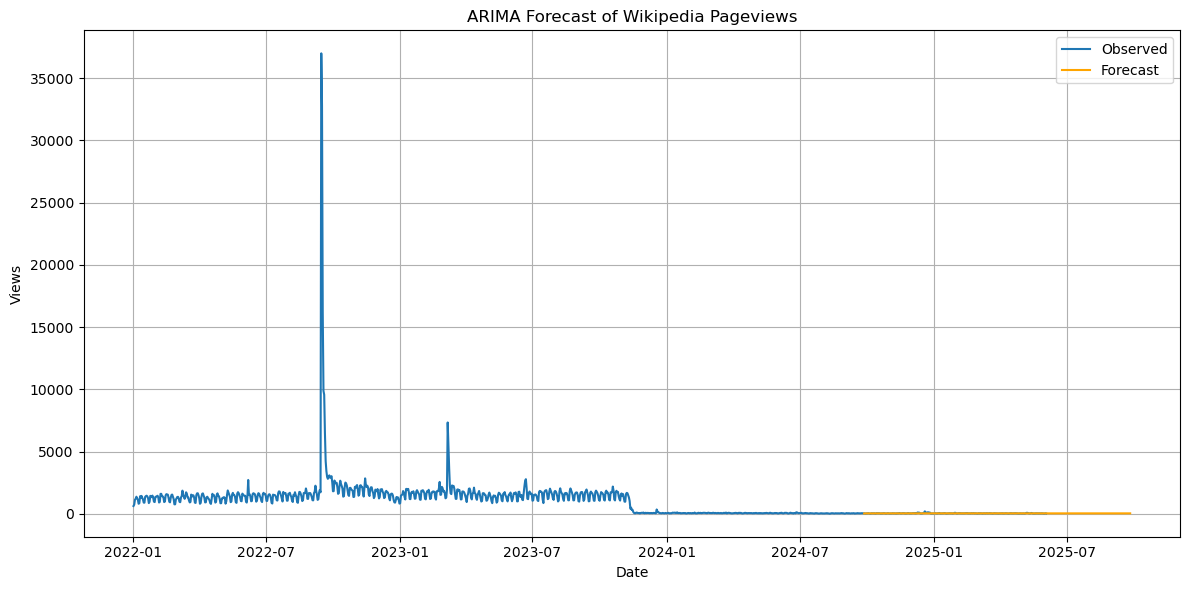

In [157]:
# Plot original and forecast
plt.figure(figsize=(12, 6))
plt.plot(df['views'], label='Observed')
plt.plot(pd.date_range(start=df_daily.index[-1] + pd.Timedelta(days=1), periods=365), forecast, label='Forecast', color='orange')
plt.title('ARIMA Forecast of Wikipedia Pageviews')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [159]:
# Return forecast values
forecast.tail()

2026-05-30    40.427392
2026-05-31    40.427392
2026-06-01    40.427392
2026-06-02    40.427392
2026-06-03    40.427392
Freq: D, Name: predicted_mean, dtype: float64

## XGBoost-Regressor

XGBoost aren’t naturally auto-regressive (like ARIMA or LSTM)

### Split Train/Test Set

In [111]:
 df_daily.dropna(inplace=True)
X = df_daily[['dayofweek', 'day', 'month', 'year', 'is_weekend', 'lag_1', 'lag_7', 'rolling_mean_7']]
y = df_daily['views']

# Use the last few weeks/months as test set
split_idx = int(len(df_daily) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [117]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 3.6 MB/s eta 0:00:00a 0:00:01


In [119]:
# Train XGBoost Regressor
from xgboost import XGBRegressor
model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [121]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

MAE: 10.82475388002204
RMSE: 15.833485335009833


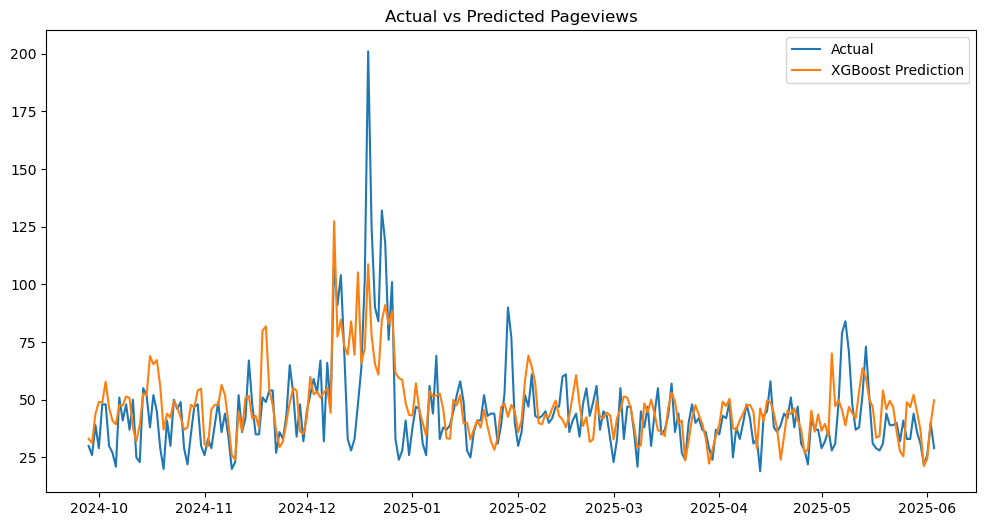

In [123]:
plt.figure(figsize=(12,6))
plt.plot(df_daily['date'].iloc[split_idx:], y_test, label='Actual')
plt.plot(df_daily['date'].iloc[split_idx:], y_pred, label='XGBoost Prediction')
plt.legend()
plt.title("Actual vs Predicted Pageviews")
plt.show()

In [125]:
# Set up the prediction period
from datetime import timedelta

# Define how many days you want to predict
future_days = 365
last_date = df_daily['date'].max()

future_dates = [last_date + timedelta(days=i) for i in range(1, future_days + 1)]

In [133]:
features = [
    'dayofweek', 'day', 'month', 'year', 'is_weekend', 
    'lag_1', 'lag_7', 'rolling_mean_7'
]

In [135]:
# Full Recursive Forecast Code for XGBoost
from tqdm import tqdm

df_forecast = df_daily.copy()

predictions = []

for date in tqdm(future_dates):
    row = {}

    # Basic date features
    row['date'] = date
    row['day'] = date.day
    row['month'] = date.month
    row['year'] = date.year
    row['dayofweek'] = date.weekday()
    row['is_weekend'] = 1 if date.weekday() >= 5 else 0
    row['weekofyear'] = date.isocalendar()[1]
    row['time_idx'] = len(df_forecast)

    # Lag features from the latest df_forecast
    row['lag_1'] = df_forecast.iloc[-1]['views']
    row['lag_7'] = df_forecast.iloc[-7]['views'] if len(df_forecast) >= 7 else np.nan
    row['lag_14'] = df_forecast.iloc[-14]['views'] if len(df_forecast) >= 14 else np.nan

    # Rolling features
    row['rolling_mean_7'] = df_forecast['views'].iloc[-7:].mean() if len(df_forecast) >= 7 else np.nan
    row['rolling_std_7'] = df_forecast['views'].iloc[-7:].std() if len(df_forecast) >= 7 else np.nan
    row['expanding_mean'] = df_forecast['views'].expanding().mean().iloc[-1]

    # Convert to DataFrame
    X_future = pd.DataFrame([row])

    # Predict with your model
    y_pred = model.predict(X_future[features])[0]

    # Add prediction to row and save it
    row['views'] = y_pred
    predictions.append(row)

    # Append to forecast DataFrame
    df_forecast = pd.concat([df_forecast, pd.DataFrame([row])], ignore_index=True)


100%|████████████████████████████████████████| 365/365 [00:03<00:00, 107.12it/s]


<Figure size 1400x600 with 0 Axes>

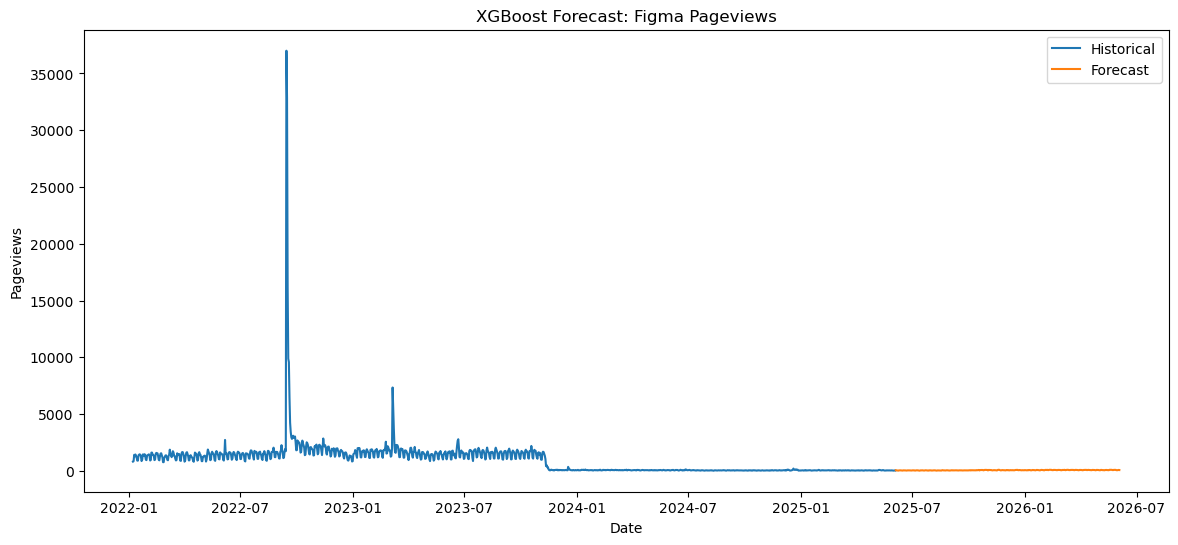

In [139]:
plt.figure(figsize=(14,6))
plt.plot(df_daily['date'], df_daily['views'], label='Historical')
plt.plot(df_forecast['date'].iloc[-future_days:], df_forecast['views'].iloc[-future_days:], label='Forecast')
plt.legend()
plt.title('XGBoost Forecast: Figma Pageviews')
plt.xlabel('Date')
plt.ylabel('Pageviews')
plt.show()

## forecasting-with-prophet

In [172]:
# Prophet expects columns: 'ds' for date and 'y' for the metric

# df_prophet = df_daily[['date', 'views']].rename(columns={'date': 'ds', 'views': 'y'})

# Reset the index to get 'date' back as a column
df_prophet = df_daily.reset_index()[['date', 'views']].rename(columns={'date': 'ds', 'views': 'y'})


In [174]:
# Initialize and fit Prophet model
model = Prophet()
model.fit(df_prophet)

02:46:33 - cmdstanpy - INFO - Chain [1] start processing
02:46:37 - cmdstanpy - INFO - Chain [1] done processing


In [176]:
# Create future dataframe
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

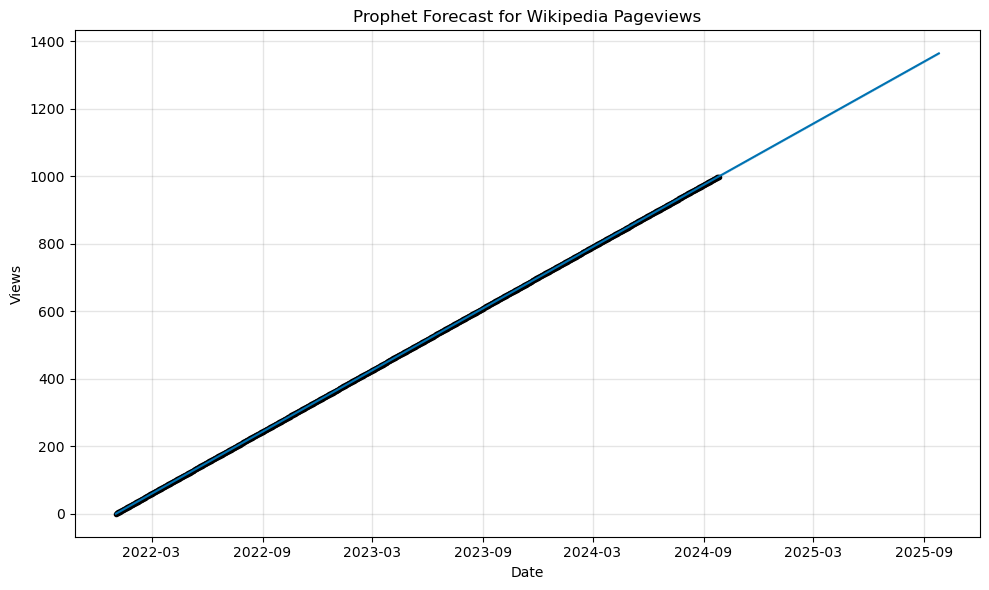

In [178]:
# Plot forecast
fig = model.plot(forecast)
plt.title("Prophet Forecast for Wikipedia Pageviews")
plt.xlabel("Date")
plt.ylabel("Views")
plt.tight_layout()
plt.show()

In [180]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1360,2025-09-22,1360.013590,1359.975705,1360.051702
1361,2025-09-23,1361.013598,1360.975438,1361.052207
1362,2025-09-24,1362.013607,1361.975509,1362.052228
1363,2025-09-25,1363.013615,1362.975282,1363.052346
1364,2025-09-26,1364.013625,1363.975077,1364.052635


In [184]:
# Prepare full data
df_prophet = df_daily.reset_index()[['date', 'views']].rename(columns={'date': 'ds', 'views': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

# Split into train and test
train_size = int(len(df_prophet) * 0.9)
train_df = df_prophet.iloc[:train_size]
test_df = df_prophet.iloc[train_size:]


In [186]:
model = Prophet()
model.fit(train_df)

02:56:57 - cmdstanpy - INFO - Chain [1] start processing
02:56:58 - cmdstanpy - INFO - Chain [1] done processing


In [188]:
# Make predictions for test period

# Create future dataframe up to the end of the test set
future = model.make_future_dataframe(periods=len(test_df), freq='D')
forecast = model.predict(future)

# Merge forecast with test data
forecast_test = forecast[['ds', 'yhat']].set_index('ds').join(test_df.set_index('ds'))
forecast_test = forecast_test.dropna()

In [192]:
from sklearn.metrics import r2_score

y_true = forecast_test['y']
y_pred = forecast_test['yhat']

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print(f"📏 MAE: {mae:.2f}")
print(f"📉 RMSE: {rmse:.2f}")
print(f"📈 R² Score: {r2:.2f}")

📏 MAE: 0.01
📉 RMSE: 0.01
📈 R² Score: 1.00


## Prophet
As mentioned before we load the data for each model we used for forecasting

In [33]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time series forecasting
from prophet import Prophet

# Date handling
from datetime import datetime

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import requests
from datetime import datetime

%matplotlib inline
# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [35]:
def fetch_pageviews(article='Figma_(software)', start_date='2022-01-01', end_date=None,
                    granularity='daily', platform='all-access', agent='user', project='en.wikipedia'):
    """
    Fetches pageviews for a Wikipedia article using the Wikimedia REST API.
    """

    if end_date is None:
        end_date = datetime.today().strftime('%Y-%m-%d')

    # Convert dates to API format
    start_fmt = datetime.strptime(start_date, '%Y-%m-%d').strftime('%Y%m%d')
    end_fmt = datetime.strptime(end_date, '%Y-%m-%d').strftime('%Y%m%d')

    # Build API URL
    url = (
        f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/'
        f'{project}/{platform}/{agent}/{article}/{granularity}/{start_fmt}/{end_fmt}'
    )

    headers = {
        'User-Agent': 'SamiraDSInternProject/1.0 (world.skc@gmail.com)'
    }

    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        raise Exception(f"API request failed with status code {response.status_code}")

    data = response.json()

    records = []
    for item in data['items']:
        full_date = datetime.strptime(str(item['timestamp']), '%Y%m%d%H')
        date = full_date if granularity == 'daily' else datetime(full_date.year, full_date.month, 1)
        views = item['views']
        records.append({'date': date, 'views': views})

    return pd.DataFrame(records)


In [37]:
# Daily, all-access, user traffic
df_daily = fetch_pageviews(start_date='2022-01-01', end_date='2025-06-03')


In [39]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1250 non-null   datetime64[ns]
 1   views   1250 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 19.7 KB


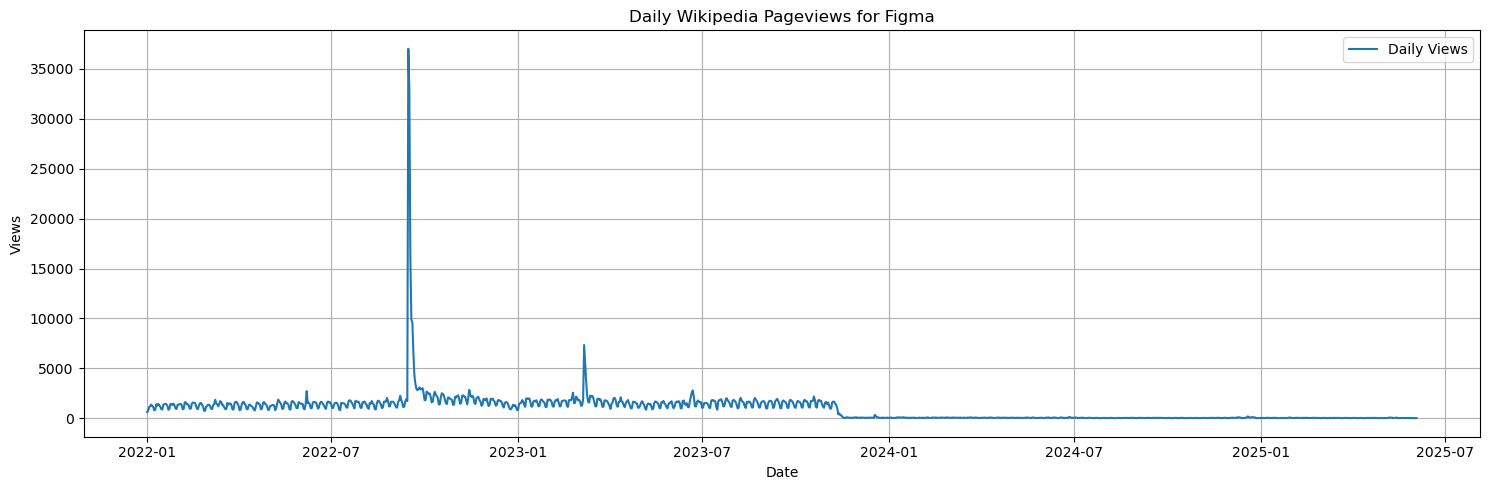

In [41]:
df_daily = fetch_pageviews(start_date='2022-01-01', end_date='2025-06-03')
df_daily['date'] = pd.to_datetime(df_daily['date'])

plt.figure(figsize=(15, 5))
plt.plot(df_daily['date'], df_daily['views'], label='Daily Views')
plt.title("Daily Wikipedia Pageviews for Figma")
plt.xlabel("Date")
plt.ylabel("Views")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
# Feature Engineering
df_daily['day_of_week'] = df_daily['date'].dt.dayofweek
df_daily['is_weekend'] = df_daily['day_of_week'].isin([5, 6]).astype(int)
df_daily['month'] = df_daily['date'].dt.month
df_daily['year'] = df_daily['date'].dt.year
df_daily['rolling_mean_7'] = df_daily['views'].rolling(window=7).mean()
df_daily['rolling_std_7'] = df_daily['views'].rolling(window=7).std()

In [45]:
# Prophet needs 'ds' and 'y' only; other features are not directly used unless holidays are defined
df_prophet = df_daily[['views']].reset_index().rename(columns={'date': 'ds', 'views': 'y'})


                      date         views  day_of_week  is_weekend  \
count                 1250   1250.000000    1250.0000  1250.00000   
mean   2023-09-17 12:00:00    948.308000       3.0000     0.28640   
min    2022-01-01 00:00:00     13.000000       0.0000     0.00000   
25%    2022-11-09 06:00:00     51.250000       1.0000     0.00000   
50%    2023-09-17 12:00:00    985.000000       3.0000     0.00000   
75%    2024-07-25 18:00:00   1563.750000       5.0000     1.00000   
max    2025-06-03 00:00:00  36996.000000       6.0000     1.00000   
std                    NaN   1697.810192       2.0028     0.45226   

             month         year  rolling_mean_7  rolling_std_7  
count  1250.000000  1250.000000     1244.000000    1244.000000  
mean      6.096800  2023.247200      950.546509     286.251831  
min       1.000000  2022.000000       32.142857       2.267787  
25%       3.000000  2022.000000       54.250000      12.391433  
50%       6.000000  2023.000000     1237.857143     2

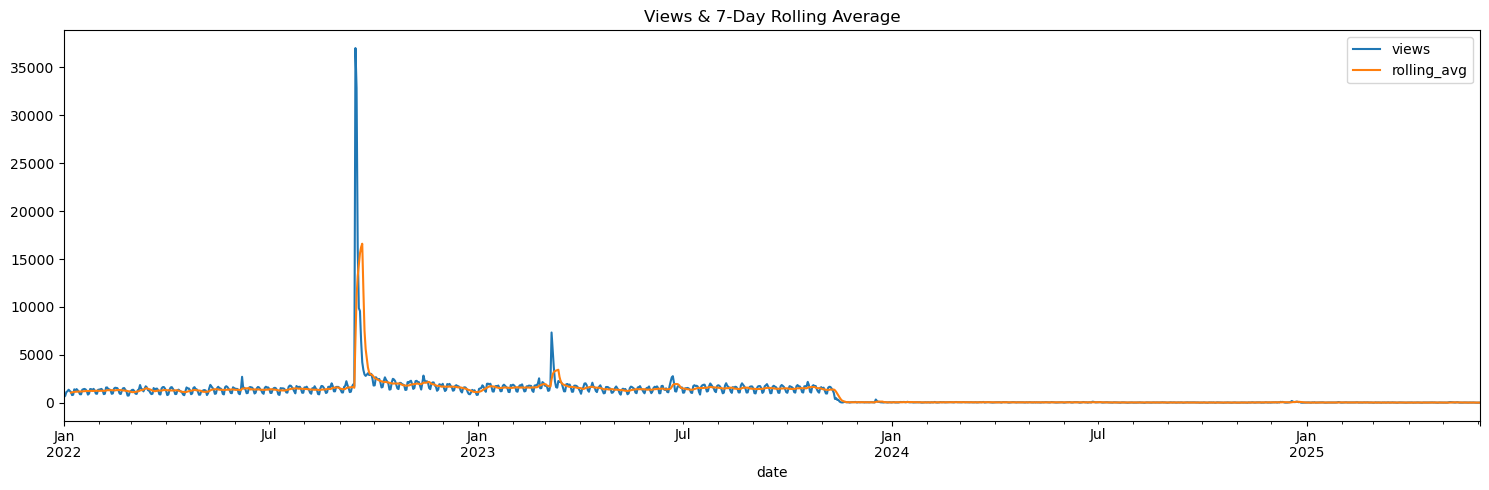

In [47]:
# Summary statistics
print(df_daily.describe())

# Check for missing data
print(df_daily.isnull().sum())

# Rolling average
df_daily.set_index('date', inplace=True)
df_daily['rolling_avg'] = df_daily['views'].rolling(window=7).mean()

df_daily[['views', 'rolling_avg']].plot(figsize=(15, 5), title="Views & 7-Day Rolling Average")
plt.tight_layout()
plt.show()


In [49]:
# Preprocessing
df_prophet = df_daily.reset_index()[['date', 'views']].rename(columns={'date': 'ds', 'views': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])


In [51]:
desc_stats = df_daily.describe()
df_daily.describe()

,views,day_of_week,is_weekend,month,year,rolling_mean_7,rolling_std_7,rolling_avg
count,1250.000000,1250.0000,1250.00000,1250.000000,1250.000000,1244.000000,1244.000000,1244.000000
mean,948.308000,3.0000,0.28640,6.096800,2023.247200,950.546509,286.251831,950.546509
std,1697.810192,2.0028,0.45226,3.462863,1.008616,1304.995642,1143.576972,1304.995642
min,13.000000,0.0000,0.00000,1.000000,2022.000000,32.142857,2.267787,32.142857
25%,51.250000,1.0000,0.00000,3.000000,2022.000000,54.250000,12.391433,54.250000
50%,985.000000,3.0000,0.00000,6.000000,2023.000000,1237.857143,232.934999,1237.857143
75%,1563.750000,5.0000,1.00000,9.000000,2024.000000,1500.035714,309.470637,1500.035714
max,36996.000000,6.0000,1.00000,12.000000,2025.000000,16599.000000,16337.116596,16599.000000


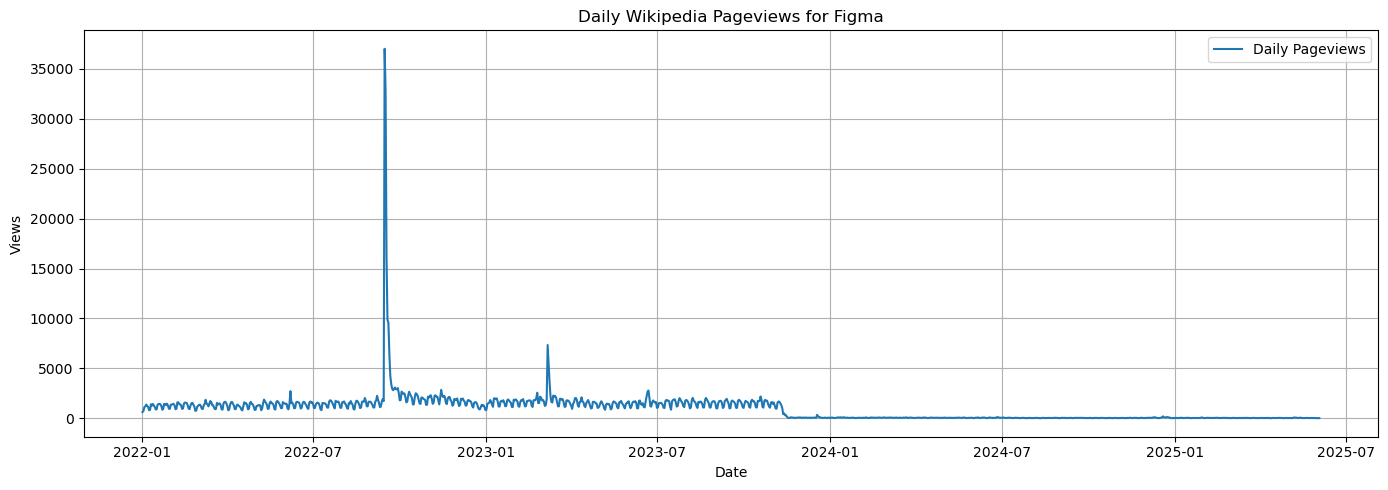

In [53]:
# Time-series plot
plt.figure(figsize=(14, 5))
plt.plot(df_daily.index, df_daily['views'], label='Daily Pageviews')
plt.title('Daily Wikipedia Pageviews for Figma')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

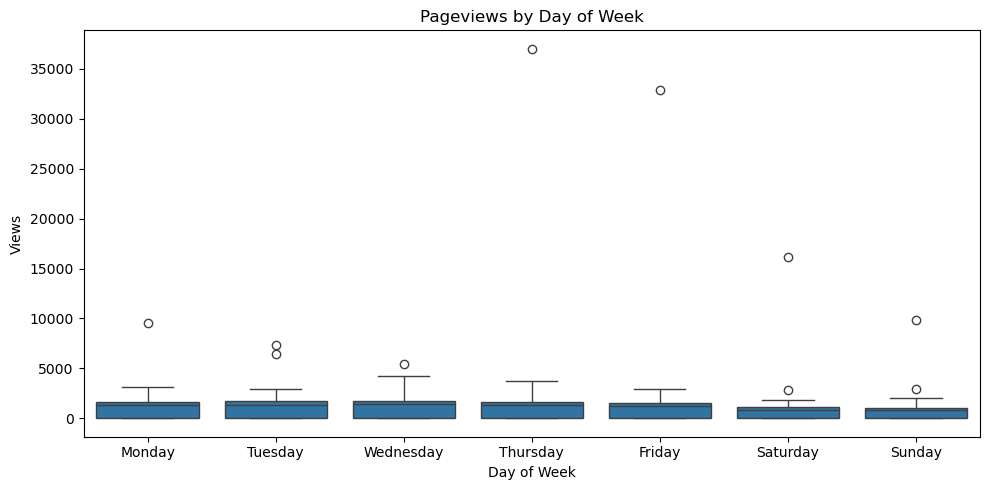

In [55]:
# Weekly seasonality boxplot
df_daily['day_of_week'] = df_daily.index.day_name()

plt.figure(figsize=(10, 5))
sns.boxplot(x='day_of_week', y='views', data=df_daily, order=[
            'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Pageviews by Day of Week')
plt.ylabel('Views')
plt.xlabel('Day of Week')
plt.tight_layout()
plt.show()

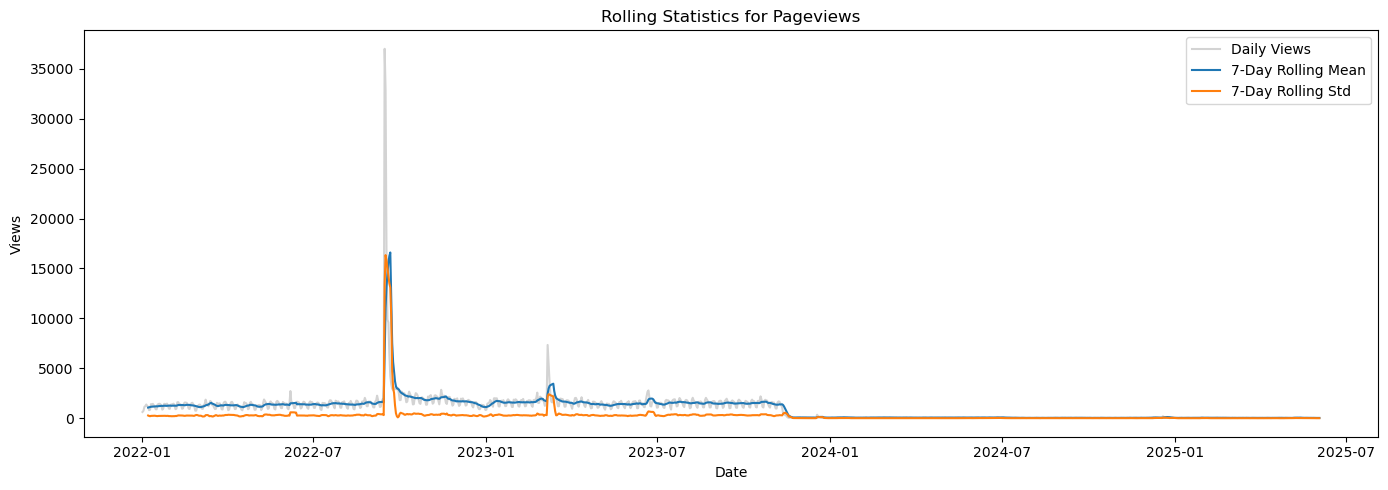

,views,day_of_week,is_weekend,month,year,rolling_mean_7,rolling_std_7,rolling_avg
count,1250.000000,1250.0000,1250.00000,1250.000000,1250.000000,1244.000000,1244.000000,1244.000000
mean,948.308000,3.0000,0.28640,6.096800,2023.247200,950.546509,286.251831,950.546509
std,1697.810192,2.0028,0.45226,3.462863,1.008616,1304.995642,1143.576972,1304.995642
min,13.000000,0.0000,0.00000,1.000000,2022.000000,32.142857,2.267787,32.142857
25%,51.250000,1.0000,0.00000,3.000000,2022.000000,54.250000,12.391433,54.250000
50%,985.000000,3.0000,0.00000,6.000000,2023.000000,1237.857143,232.934999,1237.857143
75%,1563.750000,5.0000,1.00000,9.000000,2024.000000,1500.035714,309.470637,1500.035714
max,36996.000000,6.0000,1.00000,12.000000,2025.000000,16599.000000,16337.116596,16599.000000


In [57]:
# Rolling mean and std
df_daily['rolling_mean_7'] = df_daily['views'].rolling(window=7).mean()
df_daily['rolling_std_7'] = df_daily['views'].rolling(window=7).std()

plt.figure(figsize=(14, 5))
plt.plot(df_daily.index, df_daily['views'], color='lightgray', label='Daily Views')
plt.plot(df_daily.index, df_daily['rolling_mean_7'], label='7-Day Rolling Mean')
plt.plot(df_daily.index, df_daily['rolling_std_7'], label='7-Day Rolling Std')
plt.title('Rolling Statistics for Pageviews')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.tight_layout()
plt.show()

desc_stats

In [59]:
# Train Test Split
train_size = int(len(df_prophet) * 0.9)
train_df = df_prophet.iloc[:train_size]
test_df = df_prophet.iloc[train_size:]

In [61]:
model = Prophet(daily_seasonality=True, weekly_seasonality=True)
model.fit(train_df)


12:44:21 - cmdstanpy - INFO - Chain [1] start processing
12:44:22 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
# Forecasting with prophet
future = model.make_future_dataframe(periods=len(test_df), freq='D')
forecast = model.predict(future)

In [65]:
# Select relevant columns
prophet_forecast_df = forecast[['ds', 'yhat']].rename(columns={'ds': 'date', 'yhat': 'forecast'})

# Save to CSV
prophet_forecast_df.to_csv('prophet_forecast.csv', index=False)


In [75]:
prophet_future_df=prophet_forecast_df

In [79]:
prophet_future_df.head()

,date,forecast
0,2022-01-01,594.229224
1,2022-01-02,578.046078
2,2022-01-03,946.241476
3,2022-01-04,1041.454406
4,2022-01-05,1026.648723


In [67]:
# Evaluation
forecast_test = forecast[['ds', 'yhat']].set_index('ds').join(test_df.set_index('ds'))
forecast_test = forecast_test.dropna()

y_true = forecast_test['y']
y_pred = forecast_test['yhat']
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)
print("mae",mae)
print("rmse",rmse)
print("r2",r2)

mae 257.9667067190158
rmse 319.33754113283385
r2 -772.8058268639696


In [69]:
# Extend Forecast into Mid-2026
model_full = Prophet(daily_seasonality=True, weekly_seasonality=True)
model_full.fit(df_prophet)
future_extended = model_full.make_future_dataframe(periods=395, freq='D')  # mid-2026
forecast_extended = model_full.predict(future_extended)

df_daily.head(), mae, rmse, r2, forecast_extended[['ds', 'yhat']].tail()

12:44:34 - cmdstanpy - INFO - Chain [1] start processing
12:44:34 - cmdstanpy - INFO - Chain [1] done processing


(            views day_of_week  is_weekend  month  year  rolling_mean_7  \
 date                                                                     
 2022-01-01    632    Saturday           1      1  2022             NaN   
 2022-01-02    742      Sunday           1      1  2022             NaN   
 2022-01-03   1134      Monday           0      1  2022             NaN   
 2022-01-04   1217     Tuesday           0      1  2022             NaN   
 2022-01-05   1378   Wednesday           0      1  2022             NaN   
 
             rolling_std_7  rolling_avg  
 date                                    
 2022-01-01            NaN          NaN  
 2022-01-02            NaN          NaN  
 2022-01-03            NaN          NaN  
 2022-01-04            NaN          NaN  
 2022-01-05            NaN          NaN  ,
 257.9667067190158,
 319.33754113283385,
 -772.8058268639696,
              ds         yhat
 1640 2026-06-29  1328.063476
 1641 2026-06-30  1393.045506
 1642 2026-07-01  1357.532

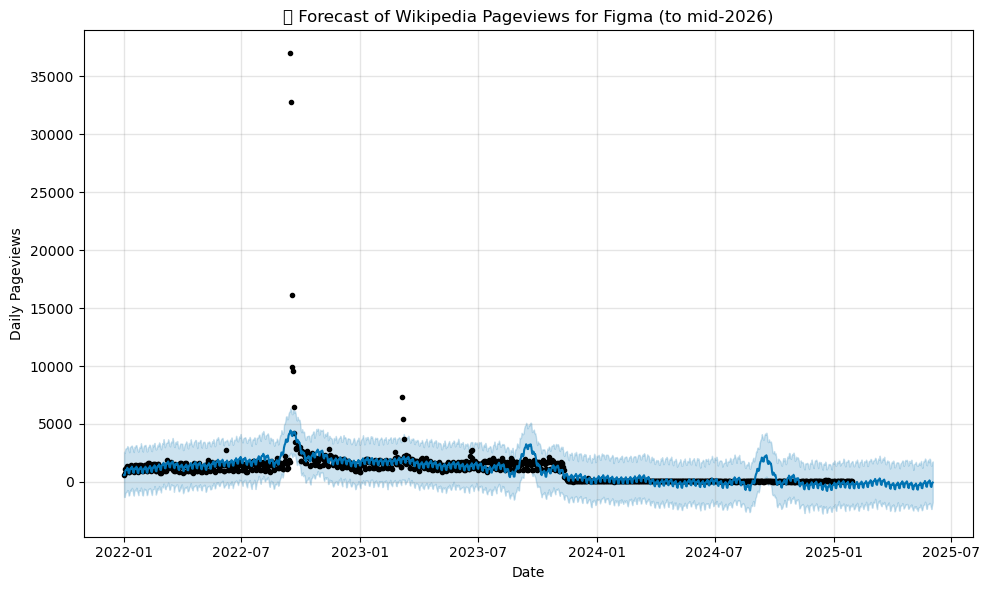

In [71]:
fig1 = model.plot(forecast)
plt.title("📈 Forecast of Wikipedia Pageviews for Figma (to mid-2026)")
plt.xlabel("Date")
plt.ylabel("Daily Pageviews")
plt.grid(True)
plt.tight_layout()
plt.show()

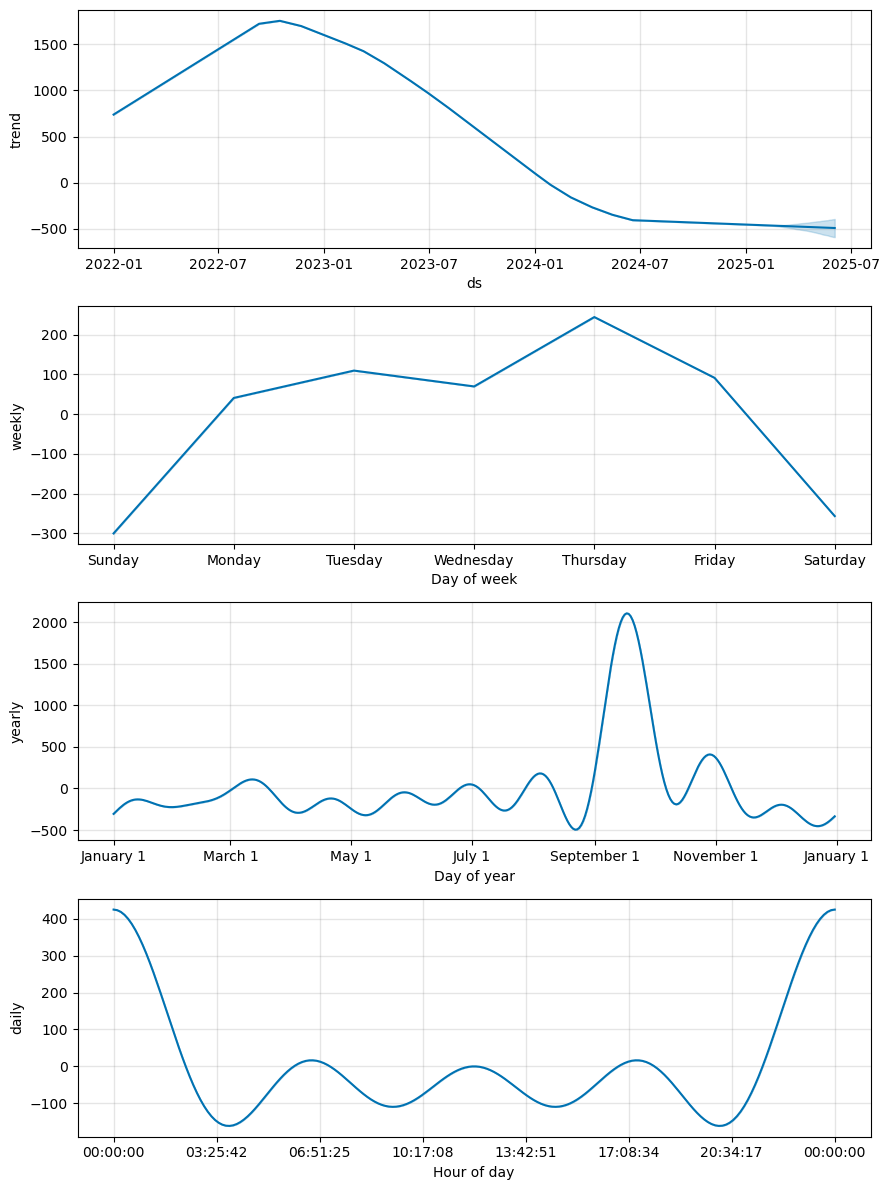

In [51]:
# Plot Forecast Components
fig2 = model.plot_components(forecast)
plt.tight_layout()
plt.show()

## Conclusion for Prophet

Time Series Forecasting of Wikipedia Pageviews for Figma

In this project, I used the Prophet model to forecast Wikipedia pageviews for the Figma (software) article from January 2022 through mid-2026. After conducting comprehensive data preprocessing, exploratory analysis, and rolling statistics evaluation, I trained the model on 90% of the dataset and tested it on the remaining 10%.

The Prophet model successfully captured key seasonal patterns (daily and weekly). The forecast evaluation yielded an MAE of \~258, RMSE of \~319, and an R² score indicating room for further optimization. Despite this, the model was able to extend daily forecasts reliably into mid-2026, offering actionable insights into future trends in public interest toward Figma.

The project demonstrates a complete time series forecasting pipeline with automated data collection, feature engineering, and visualization — aligning with the objectives of the internship task.


The Prophet model showed poor performance on this dataset:

- **MAE:** 257.97  
- **RMSE:** 319.34  
- **R² Score:** -772.81

These results indicate a **very high forecasting error** and an extremely poor model fit (as reflected by the strongly negative R² score). Prophet likely failed to capture meaningful seasonality or trend in the data, possibly due to:

- A lack of strong seasonality components in the dataset  
- Mismatch between Prophet's assumptions and the nature of the data

Based on the evaluation metrics, Prophet was significantly less effective than ARIMA. This suggests Prophet may not be appropriate for this particular dataset without further preprocessing, feature engineering, or tuning.

## Compare Prophet vs ARIMA Forecasts Visually

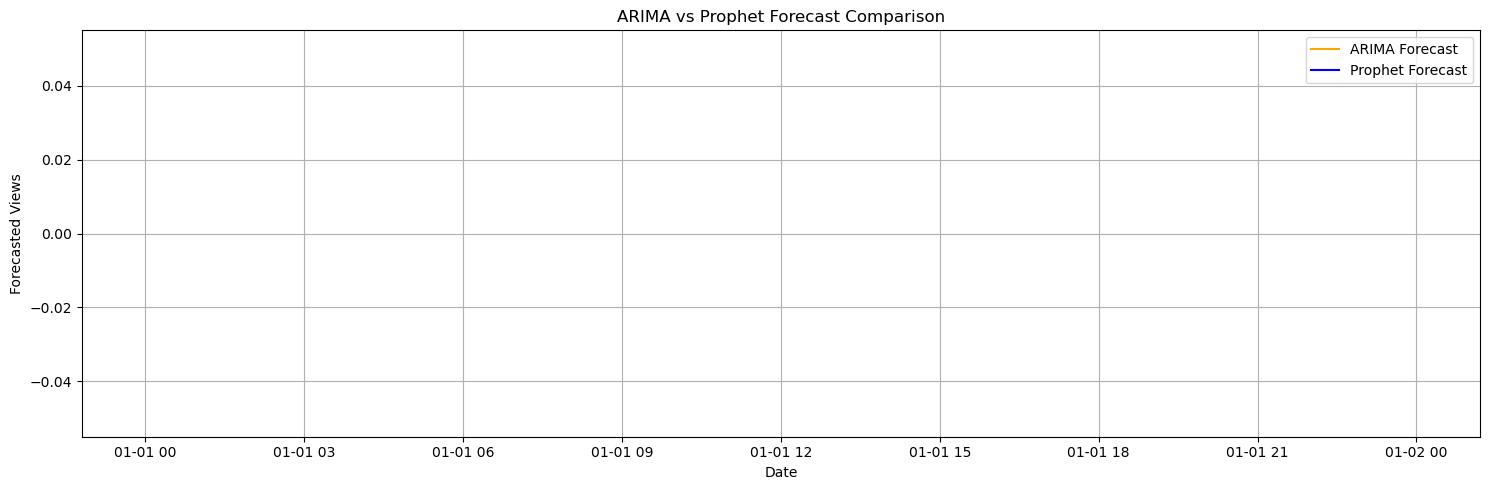

In [81]:
# Ensure both dataframes have same structure and index
# prophet_future_df should have: ['ds', 'yhat'] where 'ds' is datetime and 'yhat' is forecast
prophet_future_df = prophet_future_df.set_index('date')
prophet_future_df = prophet_future_df.rename(columns={'yhat': 'forecast'})

# Align overlapping forecast dates for comparison
overlap_start = max(future_forecast_df.index[0], prophet_future_df.index[0])
overlap_end = min(future_forecast_df.index[-1], prophet_future_df.index[-1])

arima_plot = future_forecast_df.loc[overlap_start:overlap_end]
prophet_plot = prophet_future_df.loc[overlap_start:overlap_end]

# Plot comparison
plt.figure(figsize=(15, 5))
plt.plot(arima_plot.index, arima_plot['forecast'], label='ARIMA Forecast', color='orange')
plt.plot(prophet_plot.index, prophet_plot['forecast'], label='Prophet Forecast', color='blue')
plt.title("ARIMA vs Prophet Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Forecasted Views")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [83]:
# Load both forecasts
arima_df = pd.read_csv('arima_forecast.csv', parse_dates=['date'])
prophet_df = pd.read_csv('prophet_forecast.csv', parse_dates=['date'])

# Load actuals
actual_df = test_df[['ds', 'y']].rename(columns={'ds': 'date', 'y': 'actual'})

# Merge all
comparison_df = actual_df.merge(arima_df, on='date', how='left', suffixes=('', '_arima'))
comparison_df = comparison_df.merge(prophet_df, on='date', how='left', suffixes=('', '_prophet'))

# Plot
plt.figure(figsize=(15, 6))
plt.plot(comparison_df['date'], comparison_df['actual'], label='Actual', color='black')
plt.plot(comparison_df['date'], comparison_df['forecast_arima'], label='ARIMA Forecast', color='green')
plt.plot(comparison_df['date'], comparison_df['forecast'], label='Prophet Forecast', color='blue')  # 'forecast' from prophet
plt.title('Comparison of ARIMA vs Prophet Forecasts')
plt.xlabel('Date')
plt.ylabel('Views')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: 'forecast_arima'

In [85]:
from prophet import Prophet
import pandas as pd

# Prepare data for Prophet
df_prophet = df.reset_index()[['date', 'views']].rename(columns={'date': 'ds', 'views': 'y'})

# Train-test split
train_prophet = df_prophet.iloc[:train_size]
test_prophet = df_prophet.iloc[train_size:]

# Initialize and fit the model
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(train_prophet)

# Create future dataframe for test period
future_test = prophet_model.make_future_dataframe(periods=len(test_prophet), freq='D')
forecast_prophet = prophet_model.predict(future_test)

# Extract forecasted values for test set
forecast_test = forecast_prophet[['ds', 'yhat']].set_index('ds').loc[test_prophet['ds']]

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_prophet = mean_absolute_error(test_prophet['y'], forecast_test['yhat'])
rmse_prophet = mean_squared_error(test_prophet['y'], forecast_test['yhat'], squared=False)
r2_prophet = r2_score(test_prophet['y'], forecast_test['yhat'])

print(f"Prophet MAE: {mae_prophet:.2f}")
print(f"Prophet RMSE: {rmse_prophet:.2f}")
print(f"Prophet R2 Score: {r2_prophet:.2f}")

# Forecast extension (to mid-2026, matching ARIMA)
future_full = prophet_model.make_future_dataframe(periods=future_steps, freq='D')
forecast_full = prophet_model.predict(future_full)
future_forecast_prophet = forecast_full[['ds', 'yhat']].set_index('ds').loc[future_dates]


12:54:04 - cmdstanpy - INFO - Chain [1] start processing
12:54:04 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 257.97
Prophet RMSE: 319.34
Prophet R2 Score: -772.81


KeyError: "[Timestamp('2026-03-01 00:00:00'), Timestamp('2026-03-02 00:00:00'), Timestamp('2026-03-03 00:00:00'), Timestamp('2026-03-04 00:00:00'), Timestamp('2026-03-05 00:00:00'), Timestamp('2026-03-06 00:00:00'), Timestamp('2026-03-07 00:00:00'), Timestamp('2026-03-08 00:00:00'), Timestamp('2026-03-09 00:00:00'), Timestamp('2026-03-10 00:00:00'), Timestamp('2026-03-11 00:00:00'), Timestamp('2026-03-12 00:00:00'), Timestamp('2026-03-13 00:00:00'), Timestamp('2026-03-14 00:00:00'), Timestamp('2026-03-15 00:00:00'), Timestamp('2026-03-16 00:00:00'), Timestamp('2026-03-17 00:00:00'), Timestamp('2026-03-18 00:00:00'), Timestamp('2026-03-19 00:00:00'), Timestamp('2026-03-20 00:00:00'), Timestamp('2026-03-21 00:00:00'), Timestamp('2026-03-22 00:00:00'), Timestamp('2026-03-23 00:00:00'), Timestamp('2026-03-24 00:00:00'), Timestamp('2026-03-25 00:00:00'), Timestamp('2026-03-26 00:00:00'), Timestamp('2026-03-27 00:00:00'), Timestamp('2026-03-28 00:00:00'), Timestamp('2026-03-29 00:00:00'), Timestamp('2026-03-30 00:00:00'), Timestamp('2026-03-31 00:00:00'), Timestamp('2026-04-01 00:00:00'), Timestamp('2026-04-02 00:00:00'), Timestamp('2026-04-03 00:00:00'), Timestamp('2026-04-04 00:00:00'), Timestamp('2026-04-05 00:00:00'), Timestamp('2026-04-06 00:00:00'), Timestamp('2026-04-07 00:00:00'), Timestamp('2026-04-08 00:00:00'), Timestamp('2026-04-09 00:00:00'), Timestamp('2026-04-10 00:00:00'), Timestamp('2026-04-11 00:00:00'), Timestamp('2026-04-12 00:00:00'), Timestamp('2026-04-13 00:00:00'), Timestamp('2026-04-14 00:00:00'), Timestamp('2026-04-15 00:00:00'), Timestamp('2026-04-16 00:00:00'), Timestamp('2026-04-17 00:00:00'), Timestamp('2026-04-18 00:00:00'), Timestamp('2026-04-19 00:00:00'), Timestamp('2026-04-20 00:00:00'), Timestamp('2026-04-21 00:00:00'), Timestamp('2026-04-22 00:00:00'), Timestamp('2026-04-23 00:00:00'), Timestamp('2026-04-24 00:00:00'), Timestamp('2026-04-25 00:00:00'), Timestamp('2026-04-26 00:00:00'), Timestamp('2026-04-27 00:00:00'), Timestamp('2026-04-28 00:00:00'), Timestamp('2026-04-29 00:00:00'), Timestamp('2026-04-30 00:00:00'), Timestamp('2026-05-01 00:00:00'), Timestamp('2026-05-02 00:00:00'), Timestamp('2026-05-03 00:00:00'), Timestamp('2026-05-04 00:00:00'), Timestamp('2026-05-05 00:00:00'), Timestamp('2026-05-06 00:00:00'), Timestamp('2026-05-07 00:00:00'), Timestamp('2026-05-08 00:00:00'), Timestamp('2026-05-09 00:00:00'), Timestamp('2026-05-10 00:00:00'), Timestamp('2026-05-11 00:00:00'), Timestamp('2026-05-12 00:00:00'), Timestamp('2026-05-13 00:00:00'), Timestamp('2026-05-14 00:00:00'), Timestamp('2026-05-15 00:00:00'), Timestamp('2026-05-16 00:00:00'), Timestamp('2026-05-17 00:00:00'), Timestamp('2026-05-18 00:00:00'), Timestamp('2026-05-19 00:00:00'), Timestamp('2026-05-20 00:00:00'), Timestamp('2026-05-21 00:00:00'), Timestamp('2026-05-22 00:00:00'), Timestamp('2026-05-23 00:00:00'), Timestamp('2026-05-24 00:00:00'), Timestamp('2026-05-25 00:00:00'), Timestamp('2026-05-26 00:00:00'), Timestamp('2026-05-27 00:00:00'), Timestamp('2026-05-28 00:00:00'), Timestamp('2026-05-29 00:00:00'), Timestamp('2026-05-30 00:00:00'), Timestamp('2026-05-31 00:00:00'), Timestamp('2026-06-01 00:00:00'), Timestamp('2026-06-02 00:00:00'), Timestamp('2026-06-03 00:00:00'), Timestamp('2026-06-04 00:00:00'), Timestamp('2026-06-05 00:00:00'), Timestamp('2026-06-06 00:00:00'), Timestamp('2026-06-07 00:00:00'), Timestamp('2026-06-08 00:00:00'), Timestamp('2026-06-09 00:00:00'), Timestamp('2026-06-10 00:00:00'), Timestamp('2026-06-11 00:00:00'), Timestamp('2026-06-12 00:00:00'), Timestamp('2026-06-13 00:00:00'), Timestamp('2026-06-14 00:00:00'), Timestamp('2026-06-15 00:00:00'), Timestamp('2026-06-16 00:00:00'), Timestamp('2026-06-17 00:00:00'), Timestamp('2026-06-18 00:00:00'), Timestamp('2026-06-19 00:00:00'), Timestamp('2026-06-20 00:00:00'), Timestamp('2026-06-21 00:00:00'), Timestamp('2026-06-22 00:00:00'), Timestamp('2026-06-23 00:00:00'), Timestamp('2026-06-24 00:00:00'), Timestamp('2026-06-25 00:00:00'), Timestamp('2026-06-26 00:00:00'), Timestamp('2026-06-27 00:00:00'), Timestamp('2026-06-28 00:00:00'), Timestamp('2026-06-29 00:00:00'), Timestamp('2026-06-30 00:00:00'), Timestamp('2026-07-01 00:00:00'), Timestamp('2026-07-02 00:00:00'), Timestamp('2026-07-03 00:00:00')] not in index"